In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import emcee

In [2]:
font = {'size'   : 15, 'family':'sans-serif'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)

In [3]:
def read_chains_backends(chainfiles):
    all_chains = []
    all_best_samples = []
    all_log_probs = []

    for chainfile in chainfiles:
        reader = emcee.backends.HDFBackend(chainfile)
        samples_input = reader.get_chain()
        burnin = int(len(samples_input) * 0.45)
        
        chain = reader.get_chain(discard=burnin, flat=True, thin=1)
        all_chains.append(chain)

        #log_prob_samples = reader.get_log_prob(discard=burnin, flat=True, thin=1)
        #bestid = np.argmax(log_prob_samples)
        #best_sample = copy.copy(samples_input[bestid])
        #all_best_samples.append(best_sample)
        #all_log_probs.append(log_prob_samples)

    return np.array(all_chains)[0]

In [4]:
def get_stats_chains(chains, percentile=0.6827):
    """
    Calculate statistics for each chain in a list of chains.

    Parameters:
    chains (list of numpy arrays): List of chains, where each chain is a 2D numpy array.
    percentile (float): Desired percentile for calculating sigma ranges. Default is 0.6827.

    Returns:
    list of dictionaries: List containing dictionaries with calculated statistics for each chain.
    """
    
    results = []

    for chain in chains:
        n_params = chain.shape[1]
        stats = {'median': [], 'sigma-': [], 'sigma+': [], 'mean': [], 'sigma': []}

        for i in range(n_params):
            data = chain[:, i]
            nb_x = len(data)
            ind_inf = int(np.floor(nb_x * (0.5 - percentile/2)))
            ind_sup = int(np.ceil(nb_x * (0.5 + percentile/2)))
            ind_med = int(np.round(nb_x * 0.5))
            data_sorted = np.sort(data)
            stats['median'].append(data_sorted[ind_med])
            stats['sigma-'].append(data_sorted[ind_inf] - data_sorted[ind_med])
            stats['sigma+'].append(data_sorted[ind_sup] - data_sorted[ind_med])
            stats['mean'].append(np.mean(data))
            stats['sigma'].append(np.std(data))

        results.append(stats)

    return results

In [5]:
def plot_triangular_chains(chains_and_labels, filled, contour_ls, contour_lws,
                           legend_labels, contour_colors, markers, params_to_show=None,
                           title=None, fontsize_title=None, title_x=None, title_y=None,
                           save_path=None, smoothing=False, params_ranges=None):
    '''
    Generate a triangular plot for multiple chains of samples.

    Args:
        chains_and_labels (list of tuples): List of tuples where each tuple contains a numpy array representing the sample chain and its corresponding labels.
        filled (list): List of True or False for filled contours or not.
        contour_ls (list): List of line styles: '-', '--', '-.', ':'.
        contour_lws (list): List of line widths.
        legend_labels (list): Labels for the legends of each chain.
        contour_colors (list): List of colors to be used.
        markers (list): List of markers for each chain.
        params_to_show (list, optional): List of parameters to be shown in the plot. Default is None.
        title (str, optional): Title of the plot. Default is None.
        fontsize_title (float, optional): Font size for the plot title.
        title_x (float, optional): x-coordinate of the plot title.
        title_y (float, optional): y-coordinate of the plot title.
        save_path (str, optional): Path to save the plot image. Default is None.
        smoothing (bool, optional): Whether to apply smoothing to the samples. Default is False.
        params_ranges (dict, optional): Dictionary with parameter names as keys and corresponding ranges as values.

    Returns:
        A beautiful triangular plot.
    '''

    # Create MCSamples instances for each chain and its labels
    samples = []
    for chain, labels in chains_and_labels:
        ranges = {}
        if params_ranges:
            for param, param_range in params_ranges.items():
                ranges[param] = param_range
        sample_instance = MCSamples(samples=chain, names=labels, ranges=ranges)
        samples.append(sample_instance)

    # If params_to_show is not provided, show all parameters
    if params_to_show is None:
        params_to_show = [labels for _, labels in chains_and_labels]

    # Apply smoothing if specified
    if smoothing:
        samples_smooth = [s.copy(settings={'mult_bias_correction_order': 1,
                                           'smooth_scale_2D': 0.7,
                                           'smooth_scale_1D': 0.7}) for s in samples]
    else:
        samples_smooth = samples

    # Plot settings
    g = plots.get_subplot_plotter()
    g.settings.figure_legend_frame = False
    g.settings.alpha_filled_add = 0.8
    g.settings.legend_fontsize = 15 #18
    g.settings.axes_labelsize = 19
    g.settings.axes_fontsize = 16
    g.settings.axis_marker_color = 'k'
    g.settings.axis_marker_lw = 1.2

    # Generate the triangular plot with selected parameters
    g.triangle_plot(samples_smooth, params_to_show,
                    filled=filled,
                    contour_ls=contour_ls,
                    contour_lws=contour_lws,
                    legend_labels=legend_labels,
                    legend_loc='upper right',
                    contour_colors=contour_colors,
                    markers=markers,
                    line_args=[{'ls': ls, 'lw': lw, 'color': color} for ls, lw, color in zip(contour_ls, contour_lws, contour_colors)])

    # Add title to the plot
    if title:
        plt.suptitle(title, fontsize=fontsize_title, x=title_x, y=title_y)

    # Save the plot to the specified path
    if save_path:
        plt.savefig(save_path)

    # Show the plot
    plt.show()

In [42]:
def plot_1D_marginals(chains_and_labels, filled, contour_ls, contour_lws,
                           legend_labels, contour_colors, markers, params_to_show=None,
                           title=None, fontsize_title=None, title_x=None, title_y=None,
                           share_y=True, nx=3, legend_ncol=2,
                           save_path=None, smoothing=False, params_ranges=None, width_inch=10, legend_fontsize=12,
                           axes_labelsize =12):
    '''
    Generate a triangular plot for multiple chains of samples.

    Args:
        chains_and_labels (list of tuples): List of tuples where each tuple contains a numpy array representing the sample chain and its corresponding labels.
        filled (list): List of True or False for filled distributions or not. (...in construction...)
        contour_ls (list): List of line styles: '-', '--', '-.', ':'.
        contour_lws (list): List of line widths.
        legend_labels (list): Labels for the legends of each chain.
        contour_colors (list): List of colors to be used.
        markers (list): List of markers for each chain.
        params_to_show (list, optional): List of parameters to be shown in the plot. Default is None.
        title (str, optional): Title of the plot. Default is None.
        fontsize_title (float, optional): Font size for the plot title.
        title_x (float, optional): x-coordinate of the plot title.
        title_y (float, optional): y-coordinate of the plot title.
        share_y (bool): Whether to share the y-axis. Default is True.
        nx (int): Number of subplots in the x-axis. Default is 3.
        legend_ncol (int): Number of columns in the legend. Default is 2.
        save_path (str, optional): Path to save the plot image. Default is None.
        smoothing (bool, optional): Whether to apply smoothing to the samples. Default is False.
        params_ranges (dict, optional): Dictionary with parameter names as keys and corresponding ranges as values.

    Returns:
        beautiful 1D plots.
    '''

    # Create MCSamples instances for each chain and its labels
    samples = []
    for chain, labels in chains_and_labels:
        ranges = {}
        if params_ranges:
            for param, param_range in params_ranges.items():
                ranges[param] = param_range
        sample_instance = MCSamples(samples=chain, names=labels, ranges=ranges)
        samples.append(sample_instance)

    # If params_to_show is not provided, show all parameters
    if params_to_show is None:
        params_to_show = [labels for _, labels in chains_and_labels]

    # Apply smoothing if specified
    if smoothing:
        samples_smooth = [s.copy(settings={'mult_bias_correction_order': 1,
                                           'smooth_scale_2D': 0.7,
                                           'smooth_scale_1D': 0.7}) for s in samples]
    else:
        samples_smooth = samples

    # Plot settings
    g = plots.get_subplot_plotter(width_inch=width_inch)
    g.settings.figure_legend_frame = False
    g.settings.alpha_filled_add = 0.8
    g.settings.legend_fontsize = legend_fontsize #14
    g.settings.axes_labelsize = axes_labelsize #19
    g.settings.axes_fontsize = 16
    g.settings.axis_marker_color = 'k'
    g.settings.axis_marker_lw = 1.2
    
    
    # Generate the 1D plots with selected parameters
    g.plots_1d(samples_smooth, params_to_show,
               share_y=share_y, filled=filled,
               contour_ls=contour_ls,
               contour_lws=contour_lws,
               #legend_labels=legend_labels,
               #legend_loc='upper right',
               contour_colors=contour_colors,
               markers=markers,
               nx=nx, #legend_ncol=legend_ncol,
               line_args=[{'ls': ls, 'lw': lw, 'color': color} for ls, lw, color in zip(contour_ls, contour_lws, contour_colors)]
              )
    
    g.add_legend(legend_labels, legend_loc='upper right', colored_text=True);

    # Add title to the plot
    if title:
        plt.suptitle(title, fontsize=fontsize_title, x=title_x, y=title_y)

    # Save the plot to the specified path
    if save_path:
        plt.savefig(save_path)

    # Show the plot
    plt.show()

In [7]:
def newchain_Folps(chain, ndim, omega_ndcm = 0.00064420):
    
    chain_new = np.zeros((len(chain), len(chain[1]) + 1))
    
    for ii in range(len(chain)):
        for jj in range(len(chain[1])):
            chain_new[ii][jj] = chain[ii][jj]
            
        chain_new[ii][ndim] = (chain[ii][1] + chain[ii][2] + omega_ndcm)/chain[ii][0]**2

    return chain_new

In [8]:
def newchain_Vel(chain, ndim):
    
    chain_new = np.zeros((len(chain), len(chain[1]) + 1))
    
    for ii in range(len(chain)):
        for jj in range(len(chain[1])):
            chain_new[ii][jj] = chain[ii][jj]
            
        chain_new[ii][ndim] = chain[ii][2]/100

    return chain_new

In [9]:
######################### READING CHAIN #####################################


chain_MinF = read_chains_backends(chainfiles=['Chain_MinFreedom_V25.h5'])
chain_MinF = newchain_Folps(chain=chain_MinF, ndim=6)
print(chain_MinF.shape)



chain_bs2Free_sigma1 = read_chains_backends(chainfiles=['Chain_MinF_and_bs2_sigmafactorbs_1_V25.h5'])
chain_bs2Free_sigma1 = newchain_Folps(chain=chain_bs2Free_sigma1, ndim=7)
print(chain_bs2Free_sigma1.shape)




chain_bs2Free_sigma3 = read_chains_backends(chainfiles=['Chain_MinF_and_bs2_sigmafactorbs_3_V25.h5'])
chain_bs2Free_sigma3 = newchain_Folps(chain=chain_bs2Free_sigma3, ndim=7)
print(chain_bs2Free_sigma3.shape)


chain_bs2Free_sigma6 = read_chains_backends(chainfiles=['Chain_MinF_and_bs2_sigmafactorbs_6_V25.h5'])
chain_bs2Free_sigma6 = newchain_Folps(chain=chain_bs2Free_sigma6, ndim=7)
print(chain_bs2Free_sigma6.shape)


chain_bs2Free_sigma12 = read_chains_backends(chainfiles=['Chain_MinF_and_bs2_sigmafactorbs_12_V25.h5'])
chain_bs2Free_sigma12 = newchain_Folps(chain=chain_bs2Free_sigma12, ndim=7)
print(chain_bs2Free_sigma12.shape)


chain_bs2Free_sigma10000 = read_chains_backends(chainfiles=['Chain_MinF_and_bs2_sigmafactorbs_10000_V25.h5'])
chain_bs2Free_sigma10000 = newchain_Folps(chain=chain_bs2Free_sigma10000, ndim=7)
print(chain_bs2Free_sigma10000.shape)



(89760, 7)
(132440, 8)
(139370, 8)
(129920, 8)
(130830, 8)
(184688, 8)


In [10]:
labels_MinF = [r'$h$', r'$\omega_{cdm}$', r'$\omega_b$', r'$\ln(10^{10}A_s)$',
                r'$b_1$', r'$b_2$', r'$\Omega_m$']

labels_MaxF = [r'$h$', r'$\omega_{cdm}$', r'$\omega_b$', r'$\ln(10^{10}A_s)$',
                r'$b_1$', r'$b_2$', r'$b_{s^2}$', r'$b_{3nl}$', r'$\Omega_m$']

labels_bs2Free = [r'$h$', r'$\omega_{cdm}$', r'$\omega_b$', r'$\ln(10^{10}A_s)$',
                r'$b_1$', r'$b_2$', r'$b_{s^2}$', r'$\Omega_m$']

In [11]:
#%matplotlib inline
#%config InlineBackend.figure_format = 'retina'
#import sys, os
#sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
#from getdist import plots, MCSamples
#import getdist
#import matplotlib.pyplot as plt
#import IPython

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import getdist
import IPython
from getdist import plots, MCSamples

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


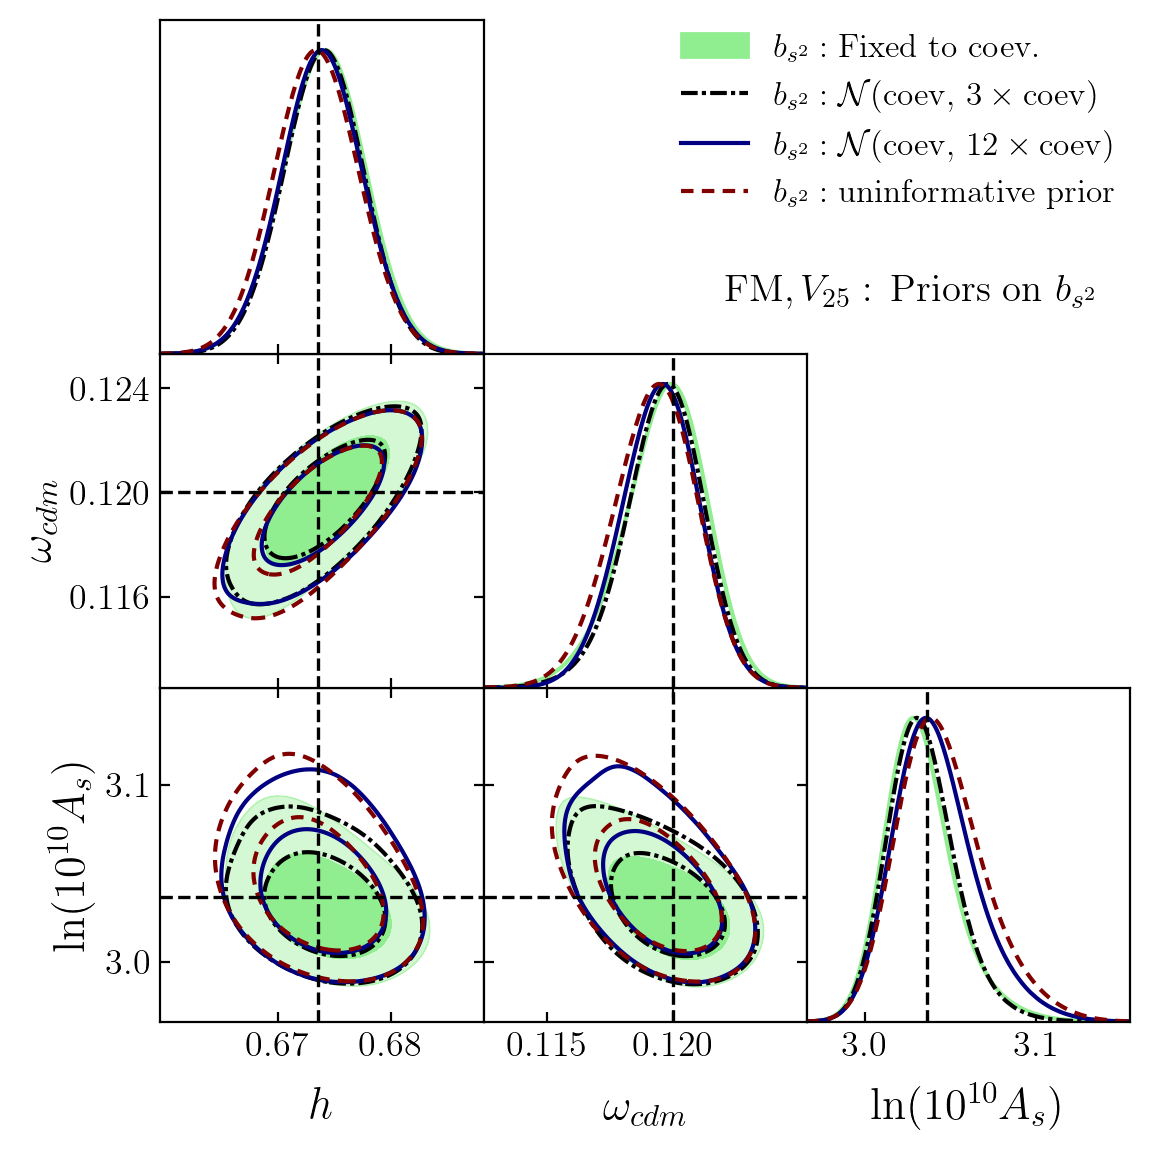

In [35]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

chains_and_labels = [
    (chain_MinF, labels_MinF),
    #(chain_bs2Free_sigma1, labels_bs2Free),
    (chain_bs2Free_sigma3, labels_bs2Free),
    #(chain_bs2Free_sigma6, labels_bs2Free),
    (chain_bs2Free_sigma12, labels_bs2Free),
    (chain_bs2Free_sigma10000, labels_bs2Free)

]


legend_labels = [
                 r'$b_{s^2}: \textnormal{Fixed to coev.}$',
                 r'$b_{s^2}: \mathcal{N}(\textnormal{coev},\, 3 \times \textnormal{coev})$',
                 #r'$b_{s^2} = \mathcal{N}(\textnormal{coev},\, 6 \times \textnormal{coev})$',
                 r'$b_{s^2}:  \mathcal{N}(\textnormal{coev},\, 12 \times \textnormal{coev})$',
                 r'$b_{s^2}: \textnormal{uninformative prior}$'
                ]

filled = [True, False, False, False, False]
contour_ls = ['-', '-.', '-', '--', ':']
contour_lws = [1.5, 1.5, 1.5, 1.5, 3]
contour_colors = ['lightgreen','black', 'navy', 'maroon','darkorange']#['green', 'dimgrey','brown']

params_to_show = [r'$h$', r'$\omega_{cdm}$',r'$\ln(10^{10}A_s)$']

markers = {r'$h$':0.6736, 
             r'$\omega_b$':0.02237,
             r'$\omega_{cdm}$':0.12,
             r'$\Omega_m$': 0.3151918679932973, 
             r'$\ln(10^{10}A_s)$':np.log(10**10 * 2.0830e-9)}


plot_triangular_chains(chains_and_labels=chains_and_labels, 
                       filled=filled, contour_ls=contour_ls, contour_lws=contour_lws,
                       legend_labels=legend_labels, contour_colors=contour_colors, markers=markers,
                       params_to_show=params_to_show,
                       title=r'$\textnormal{FM,}\,V_{25}:\,\textnormal{Priors on $b_{s^2}$}$',
                       fontsize_title=14, title_x=0.78, title_y=0.75, 
                       save_path='FM_LRG_V25_Priorsbs2.pdf',
                       smoothing=True, params_ranges=None)


In [36]:
#######################################################################################################

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


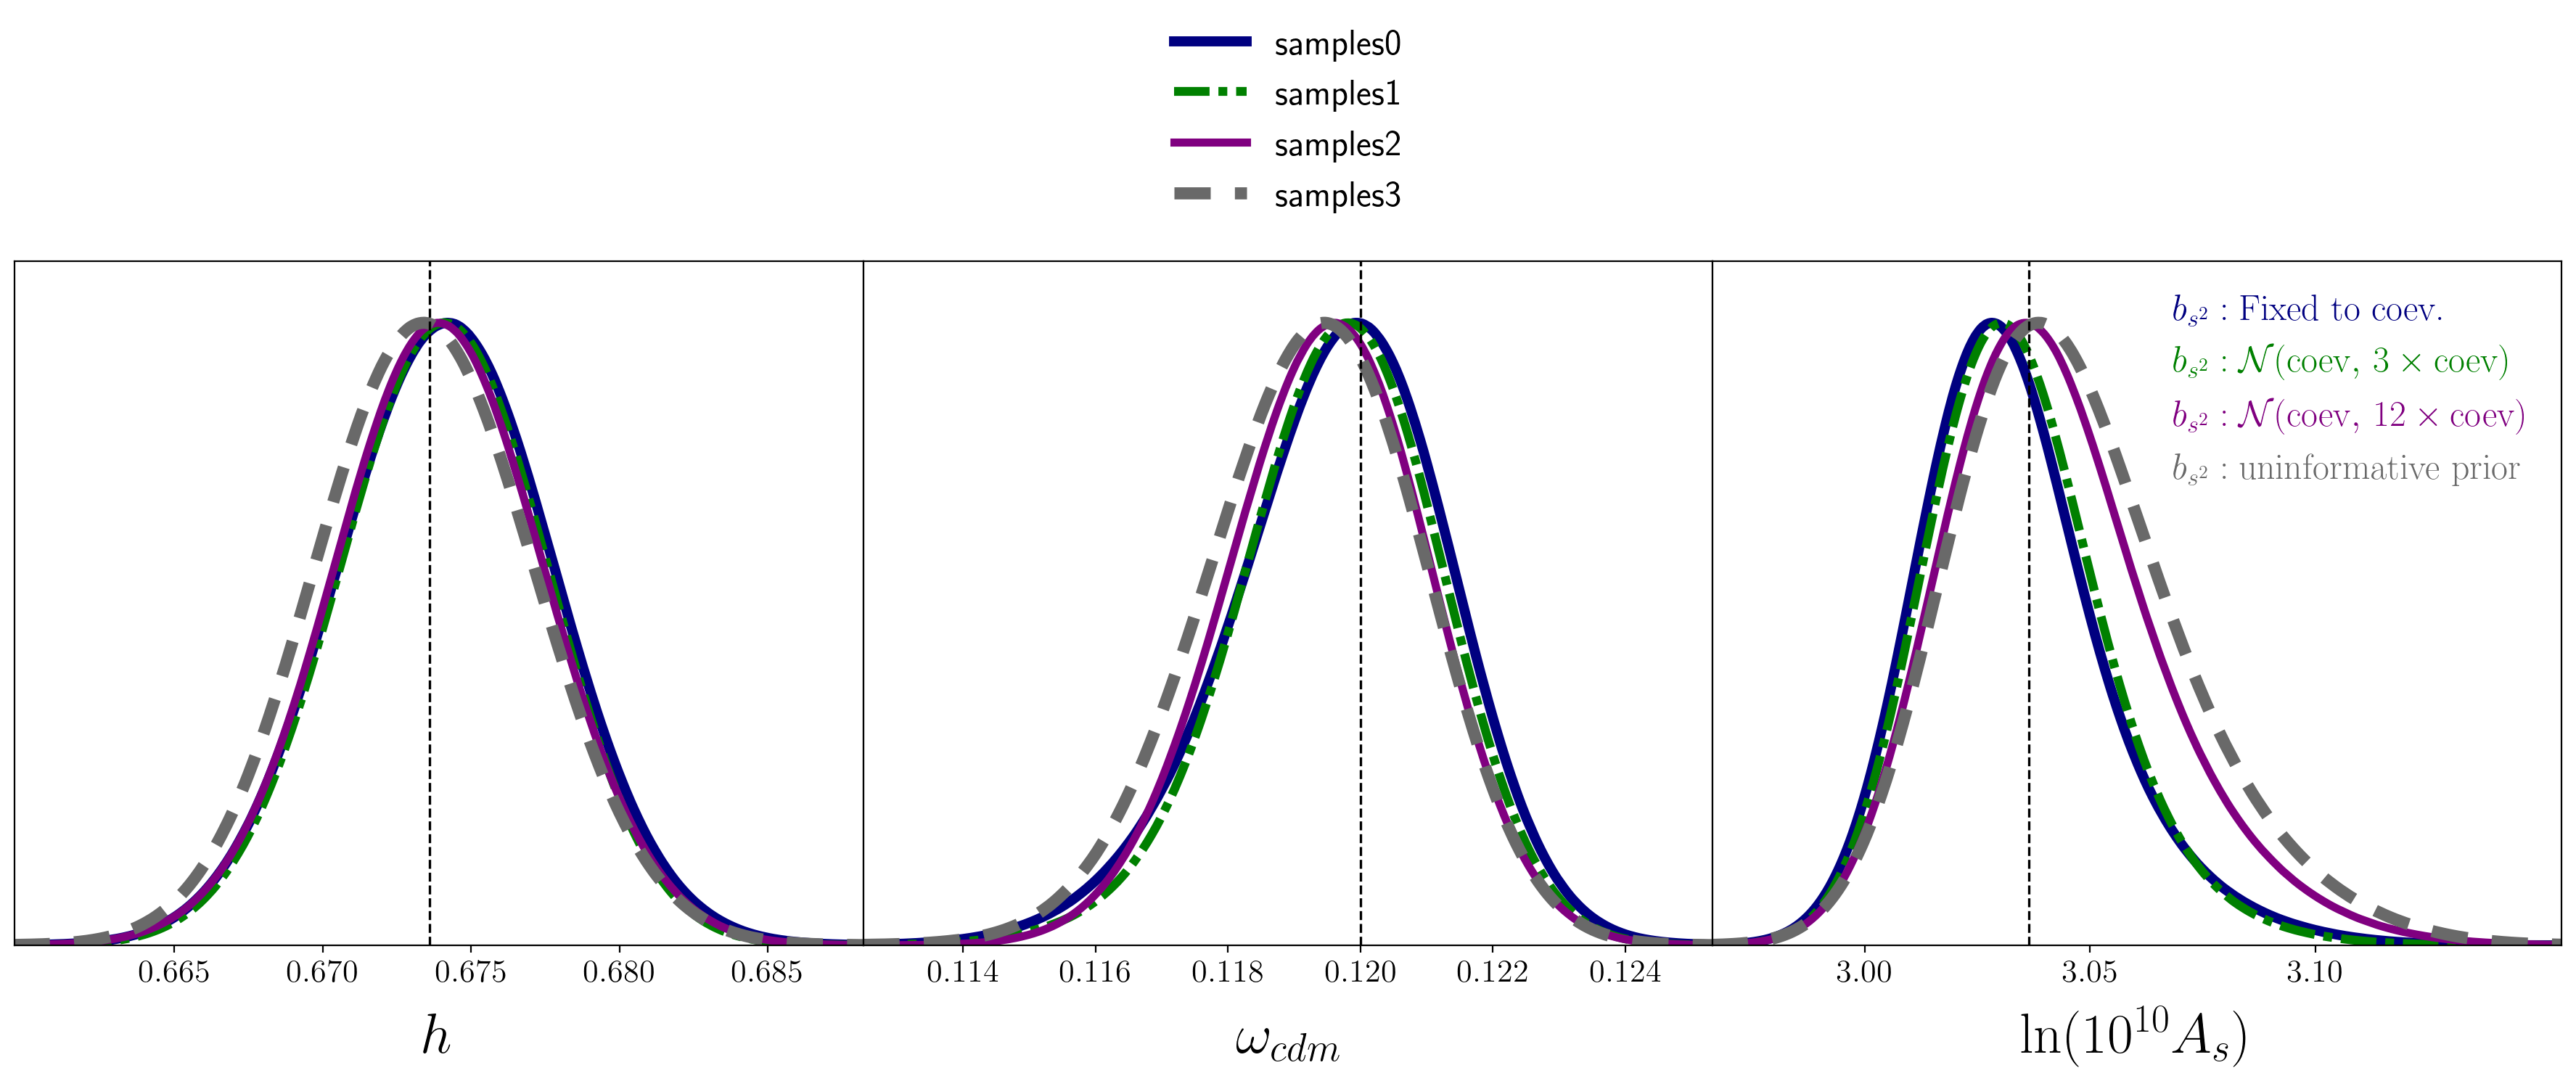

In [46]:
contour_ls = ['-', '-.', '-', '--', ':']
contour_lws = [2.5*2, 2.2*2, 2.0*2, 3*2]
contour_colors = ['navy','green', 'purple', 'dimgray']#['green', 'dimgrey','brown']'lightgreen','black', 'navy', 'maroon'

params_to_show = [r'$h$', r'$\omega_{cdm}$',r'$\ln(10^{10}A_s)$']

plot_1D_marginals(chains_and_labels, filled, contour_ls, contour_lws,
                  legend_labels, contour_colors, markers, params_to_show=params_to_show,
                  title=None,
                  fontsize_title=16, title_x=0.28, title_y=1.00,
                  share_y=True, nx=3, legend_ncol=2,
                  save_path='FM_LRG_V25_Priorsbs2_1D.pdf', smoothing=True, params_ranges=None, width_inch=18, legend_fontsize=18, 
                  axes_labelsize=28)